In [1]:
import os
#import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot.inputs.tf_keras import PlotLossesCallback

In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
tf.test.is_gpu_available(cuda_only=True)

False

In [4]:
train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.9],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
download_dir = Path(r'D:\Research\RBC\Untitled Folder\pbs_images\IDA images_with preprocess')
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'

In [6]:
BATCH_SIZE = 64
classes = ['IDA','normal']

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=classes,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=classes,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=classes,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 315 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


# Feature Extraction

#### You'll see in the create_model function the different components of our Transfer Learning model:  

>-On line 13, we assign the stack of pre-trained model layers to the variable conv_base. Note that include_top=False to exclude VGG16's pre-trained Fully-Connected layer.  
>-On lines 18-25, if the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable. Otherwise, the last n layers will be made available for training.  
>-On lines 29-30, we set up a new "top" portion of the model by grabbing the conv_base outputs and flattening them.  
>-On lines 31-33, we define the new Fully-Connected layer, which we'll train with backpropagation. We include dropout regularization to reduce over-fitting.  
>-Line 34 defines the model's output layer, where the total number of outputs is equal to n_classes.  

In [7]:
def create_model(input_shape, n_classes=2, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    return model

### Training without fine-tuning

In [8]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [9]:

plot_loss_1 = PlotLossesCallback()


# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  monitor='loss',
                                  save_best_only=True,
                                  verbose=1)
'''
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  save_freq='epoch',
                                  verbose=1)
'''
# EarlyStopping
early_stop = EarlyStopping(monitor='loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')
'''
# EarlyStopping
early_stop = EarlyStopping(patience=10,
                           restore_best_weights=True,
                           mode='min')
'''

"\n# EarlyStopping\nearly_stop = EarlyStopping(patience=10,\n                           restore_best_weights=True,\n                           mode='min')\n"

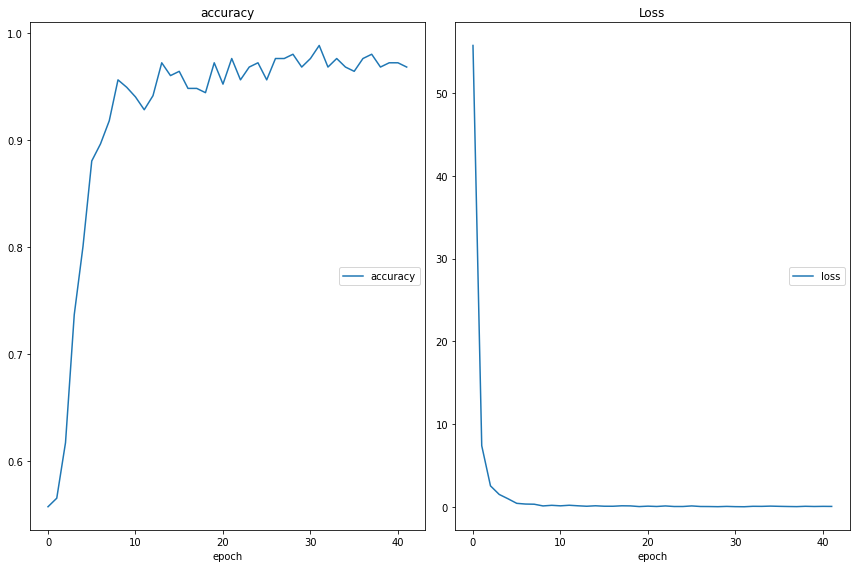

accuracy
	accuracy         	 (min:    0.558, max:    0.988, cur:    0.968)
Loss
	loss             	 (min:    0.044, max:   55.730, cur:    0.082)
Wall time: 56min 16s


In [10]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [11]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [12]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 98.48%


### Without pre-process

In [8]:
train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.9],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input)

val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
download_dir = Path(r'D:\Research\RBC\Untitled Folder\pbs_images\IDA images_without preprocess')
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'

In [11]:
BATCH_SIZE = 64
classes = ['IDA','normal']

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=classes,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(val_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=classes,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=classes,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 247 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 54 images belonging to 2 classes.


In [12]:
input_shape = (224, 224, 3)
optim_2 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model_2 = create_model(input_shape, n_classes, optim_2, fine_tune=0)

In [13]:
plot_loss_2 = PlotLossesCallback()


# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = ModelCheckpoint(filepath='tl_model_v4.weights.best.hdf5',
                                  monitor='loss',
                                  save_best_only=True,
                                  verbose=1)
'''
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  save_freq='epoch',
                                  verbose=1)
'''
# EarlyStopping
early_stop = EarlyStopping(monitor='loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')
'''
# EarlyStopping
early_stop = EarlyStopping(patience=10,
                           restore_best_weights=True,
                           mode='min')
'''

"\n# EarlyStopping\nearly_stop = EarlyStopping(patience=10,\n                           restore_best_weights=True,\n                           mode='min')\n"

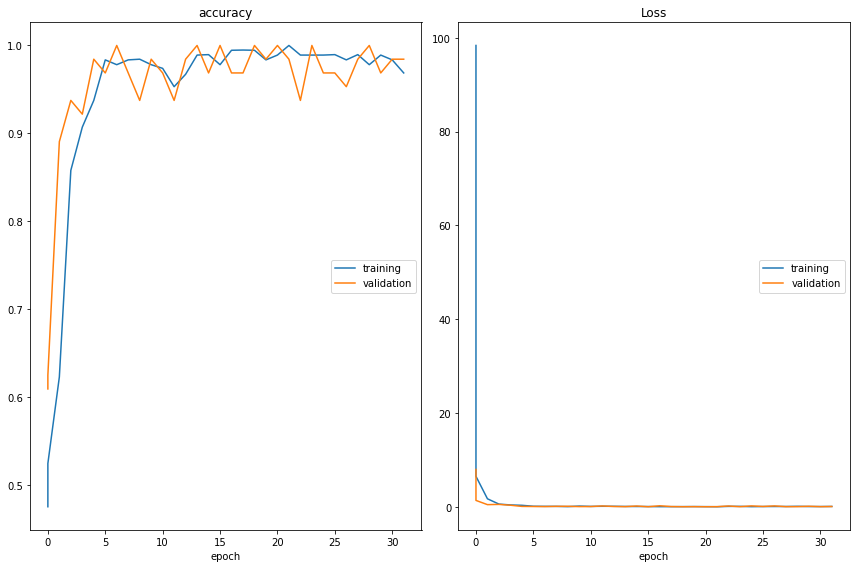

accuracy
	training         	 (min:    0.475, max:    1.000, cur:    0.969)
	validation       	 (min:    0.609, max:    1.000, cur:    0.984)
Loss
	training         	 (min:    0.005, max:   98.352, cur:    0.065)
	validation       	 (min:    0.006, max:    7.953, cur:    0.053)
Wall time: 45min 29s


In [15]:
%%time 

vgg_history_2 = vgg_model_2.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_2, early_stop, plot_loss_2],
                            verbose=1)

In [16]:
# Generate predictions
vgg_model_2.load_weights('tl_model_v4.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model_2.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [17]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 98.15%
